# Import packages

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchinfo
from torch_snippets import Report
from torchviz import make_dot
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

In [15]:
device

'mps'

# Load datasets

In [16]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

# Create class for collecting data

In [17]:
class PriceDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor(labels[1]).float().to(device)

        return features, price

    def __len__(self):
        return len(self.features)

In [18]:
temp = PriceDataset(features, labels)
in_features = len(temp[0][0])

# Build the model

In [22]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price

In [23]:
model = PredictPrice(in_features)
torchinfo.summary(model, input_size=(1, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
PredictPrice                             [1, 1]                    --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 128]                  6,656
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 128]                  16,512
│    └─ReLU: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 256]                  33,024
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Linear: 2-7                       [1, 128]                  32,896
│    └─ReLU: 2-8                         [1, 128]                  --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-9                       [1, 1]                    129
│    └─ReLU: 2-10                        [1, 1]                    --

In [25]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

features = temp[0][0].to("cpu")
yhat = model(features)
writer.add_graph(model, features)

# Data standardization

In [9]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

# Train the model
## Prepare data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

# Cross validation



-------------This is fold 0----------------
EPOCH: 1000.000	val_loss: 711068800.000	(3485.14s - 0.00s remaining))))))

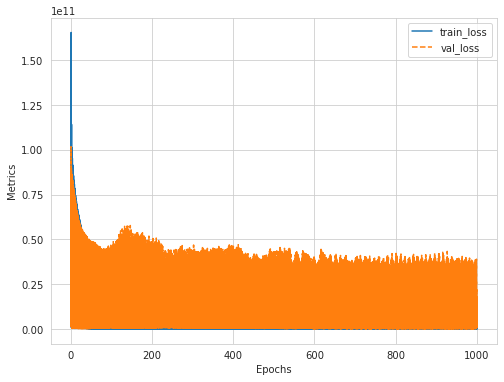



-------------This is fold 1----------------
EPOCH: 1000.000	val_loss: 5483236352.000	(3482.45s - 0.00s remaining)))))

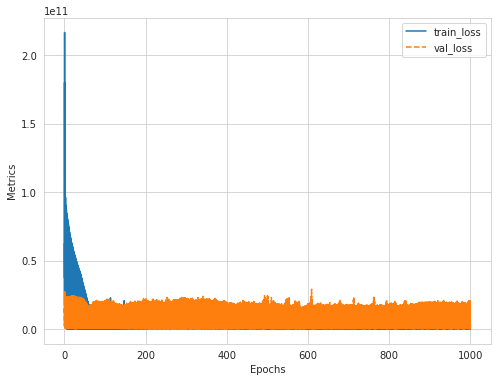



-------------This is fold 2----------------
EPOCH: 1000.000	val_loss: 1996166144.000	(3465.44s - 0.00s remaining)))))

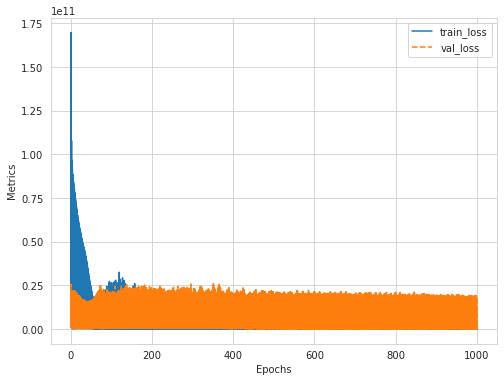



-------------This is fold 3----------------
EPOCH: 1000.000	val_loss: 1059457920.000	(2439.42s - 0.00s remaining)))))

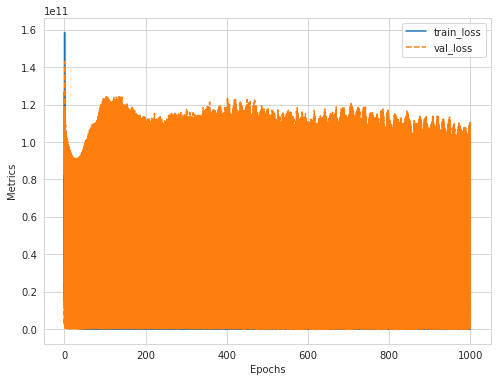



-------------This is fold 4----------------
EPOCH: 1000.000	val_loss: 336205728.000	(2444.51s - 0.00s remaining))))))

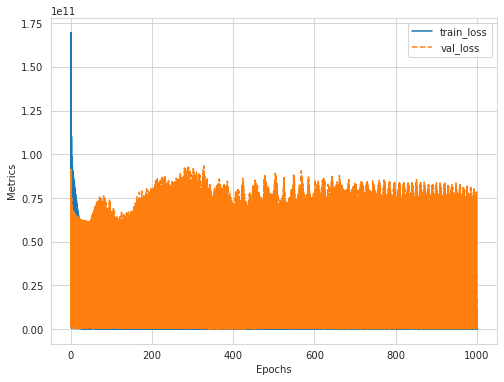

In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/all_full_epoch_1000_fold_{}.pth".format(fold))

# Testing the performance

In [88]:
filename = "models/all_full_epoch_1000_fold_1.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [89]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [90]:
pred

,PredictPrice,Price,Error
3497,0.00000,525.0,1.000000
4669,310436.25000,270000.0,0.149764
5356,590802.43750,580000.0,0.018625
5835,0.00000,385.0,1.000000
8435,0.00000,1400.0,1.000000
...,...,...,...
7173,0.00000,1300.0,1.000000
1392,464215.90625,520000.0,0.107277
3639,295281.03125,450000.0,0.343820
7216,0.00000,750.0,1.000000


In [91]:
print("MAE: ", mean_absolute_error(y_test["Price / Rent"], prices))
print("MSE: ", mean_squared_error(y_test["Price / Rent"], prices))
print("R2:", r2_score(y_test["Price / Rent"], prices))

MAE:  36538.97618325759
MSE:  4918700785.724839
R2: 0.85867385674312


# Number of sale and rental data

In [13]:
features = pd.read_csv("../datasets/final_features.csv")
sale_rent = torch.tensor(features["Sale or Let"].values)
classes, count = sale_rent.unique(return_counts=True)

In [14]:
classes, count

(tensor([0, 1]), tensor([2959, 6218]))

# Weighted random sampler

In [ ]:
weight = 1.0 / count.float()
weight

In [ ]:
sample_weights = weight[sale_rent.squeeze().long()]

In [ ]:
sample_weights[:10]

In [ ]:
sale_rent[:10]

In [ ]:
generator = torch.Generator()

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                generator=generator,
                                replacement=True)

In [ ]:
train_data = PriceDataset(features, labels)
train_loader = DataLoader(train_data, batch_size=2, sampler=sampler)

# Prepare data
## Load data

In [11]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

## Data standardization

In [12]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

## Split dataset

In [13]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

## Cross validation

In [73]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)

    train_sampler = create_weighted_sampler(train_feature["Sale or Let"].values)
    val_sampler = create_weighted_sampler(val_feature["Sale or Let"].values)

    train_loader = DataLoader(train_data, batch_size=16, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=16, drop_last=True, sampler=val_sampler)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/all_weighted_sampler_full_epoch_1000_fold_{}.pth".format(fold))



-------------This is fold 0----------------
EPOCH: 0.568	train_loss: 7531593728.000	(4.09s - 7197.89s remaining))))

KeyboardInterrupt: 

# Test performance (weighted sampler)

In [32]:
filename = "models/all_weighted_sampler_full_epoch_1000_fold_0.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [33]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [34]:
pred

,PredictPrice,Price,Error
3497,0.000000,525.0,1.000000
4669,275996.562500,270000.0,0.022209
5356,740305.687500,580000.0,0.276389
5835,0.000000,385.0,1.000000
8435,0.000000,1400.0,1.000000
...,...,...,...
7173,0.000000,1300.0,1.000000
1392,515212.937500,520000.0,0.009206
3639,396924.937500,450000.0,0.117945
7216,0.000000,750.0,1.000000


In [35]:
print("MAE: ", mean_absolute_error(y_test["Price / Rent"], prices))
print("MSE: ", mean_squared_error(y_test["Price / Rent"], prices))
print("R2:", r2_score(y_test["Price / Rent"], prices))

MAE:  34099.12480000681
MSE:  4635616774.935665
R2: 0.8668075435041918


# Separate sale and rental data
## Load datasets

In [22]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

## Split sale and rental data

In [23]:
sale_features = features[features["Sale or Let"] == 1]
sale_features = sale_features.loc[:, ~sale_features.columns.isin(["Sale or Let"])]
sale_labels = labels.iloc[sale_features.index]

rental_features = features[features["Sale or Let"] == 0]
rental_features = rental_features.loc[:, ~rental_features.columns.isin(["Sale or Let"])]
rental_labels = labels.iloc[rental_features.index]

## Data standardization

In [24]:
scaler = StandardScaler()

scaler.fit(sale_features)
scaled_sale_feature = sale_features.copy()
scaled_sale_feature[:] = scaler.fit_transform(scaled_sale_feature)

scaler.fit(rental_features)
scaled_rental_feature = rental_features.copy()
scaled_rental_feature[:] = scaler.fit_transform(scaled_rental_feature)

## Split sale data into training and validation

In [25]:
x_train, x_test, y_train, y_test = train_test_split(scaled_sale_feature, sale_labels, random_state=1, test_size=0.1)

## Train the model (sale)



-------------This is fold 0----------------
EPOCH: 1000.000	val_loss: 9753845760.000	(2334.50s - 0.00s remaining))))))

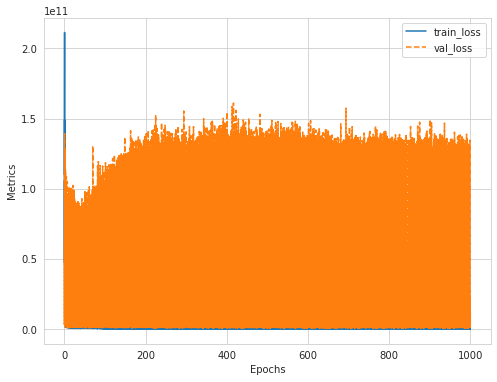



-------------This is fold 1----------------
EPOCH: 1000.000	val_loss: 4394966528.000	(2355.20s - 0.00s remaining)))))

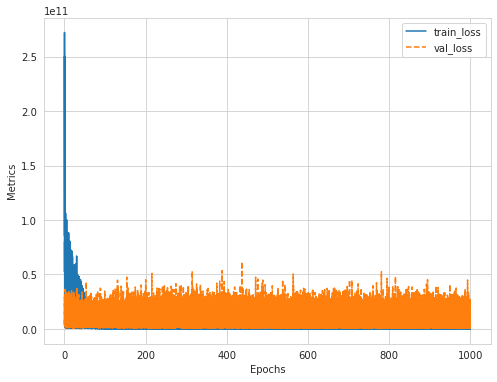



-------------This is fold 2----------------
EPOCH: 1000.000	val_loss: 4036526592.000	(2377.13s - 0.00s remaining)))))

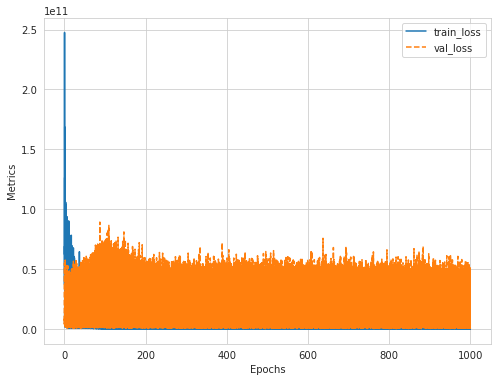



-------------This is fold 3----------------
EPOCH: 1000.000	val_loss: 6725028864.000	(2404.06s - 0.00s remaining)))))

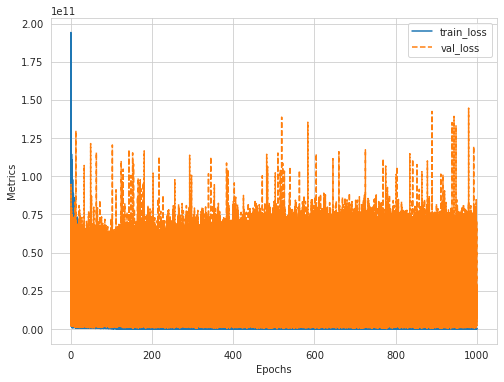



-------------This is fold 4----------------
EPOCH: 1000.000	val_loss: 11462285312.000	(2406.39s - 0.00s remaining)))))

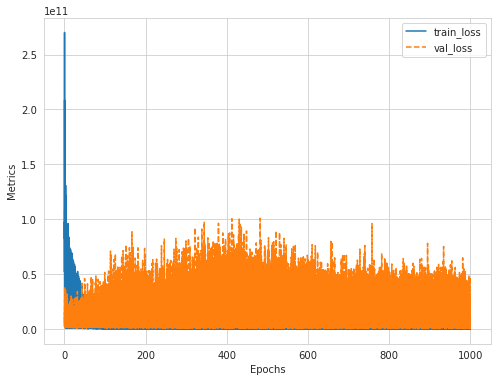

In [12]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=16, drop_last=True, shuffle=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/sale_only_full_epoch_1000_fold_{}.pth".format(fold))

## Test Performance (sale only)

In [26]:
filename = "models/sale_only_full_epoch_1000_fold_1.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [27]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [28]:
pred

,PredictPrice,Price,Error
5071,187159.593750,300000.0,0.376135
6456,348365.875000,350000.0,0.004669
3547,241875.171875,200000.0,0.209376
6245,215270.171875,220000.0,0.021499
5482,557764.937500,460000.0,0.212532
...,...,...,...
7894,217496.218750,210000.0,0.035696
5417,423593.906250,235000.0,0.802527
6981,454386.500000,450000.0,0.009748
431,157286.671875,137000.0,0.148078


In [29]:
print("MAE: ", mean_absolute_error(y_test["Price / Rent"], prices))
print("MSE: ", mean_squared_error(y_test["Price / Rent"], prices))
print("R2:", r2_score(y_test["Price / Rent"], prices))

MAE:  55976.33869762359
MSE:  7556029919.005927
R2: 0.6629154008620588


## Split rental data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(scaled_rental_feature, rental_labels, random_state=1, test_size=0.1)

## Train the model (rental)



-------------This is fold 0----------------
EPOCH: 1000.000	val_loss: 40175.992	(1117.71s - 0.00s remaining))))

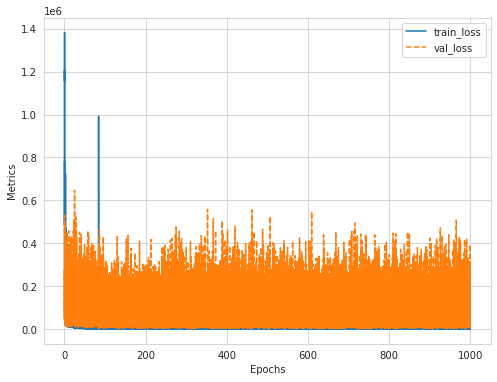



-------------This is fold 1----------------
EPOCH: 1000.000	val_loss: 116024.336	(1123.52s - 0.00s remaining)))

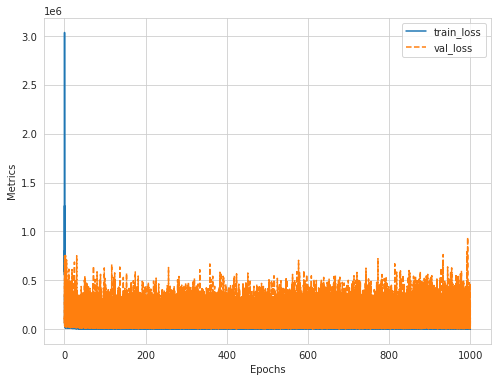



-------------This is fold 2----------------
EPOCH: 1000.000	val_loss: 21037.723	(1136.59s - 0.00s remaining))))

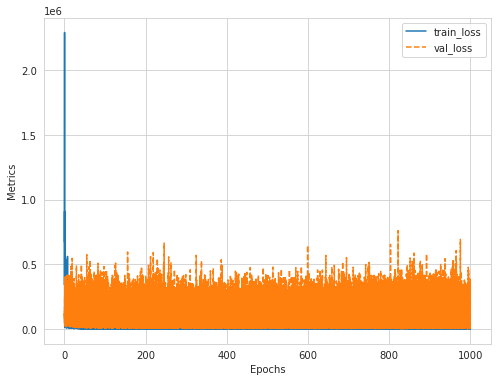



-------------This is fold 3----------------
EPOCH: 1000.000	val_loss: 26414.184	(1136.61s - 0.00s remaining)))))

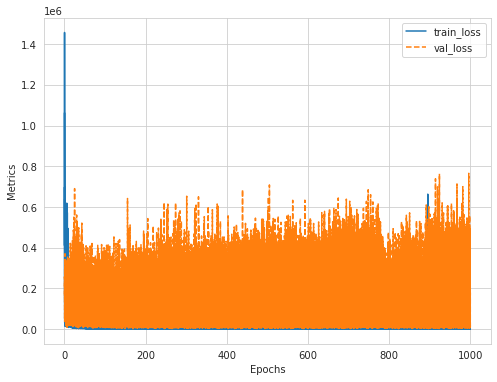



-------------This is fold 4----------------
EPOCH: 1000.000	val_loss: 32472.045	(1135.41s - 0.00s remaining))))

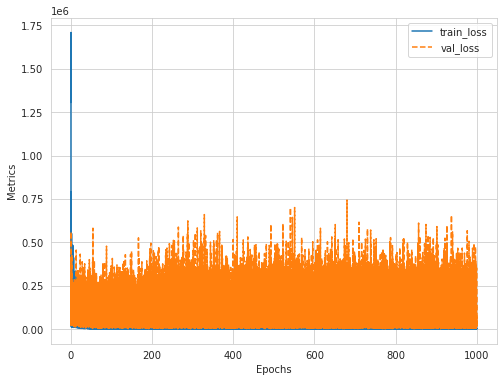

In [14]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 1000

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=16, drop_last=True, shuffle=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/rental_only_full_epoch_1000_fold_{}.pth".format(fold))

## Test performance (rental only)

In [31]:
filename = "models/rental_only_full_epoch_1000_fold_1.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()

prices = []
for i in range(len(x_test)):
    feature = torch.tensor((x_test.iloc[i])).float()
    pred_price = model(feature)
    prices.append(pred_price.detach().item())

pred = pd.DataFrame({"PredictPrice": prices, "Price": y_test["Price / Rent"]})

In [32]:
error = []
for i in range(len(pred)):
    truth = pred["Price"].iloc[i]
    predict = pred["PredictPrice"].iloc[i]
    error.append(abs(truth - predict) / truth)

avg_error = sum(error) / len(error)
error = pd.DataFrame({"Error": error})
error = error.rename(index={i: j for i, j in zip(error.index, pred.index)})
pred = pd.concat([pred, error], axis=1)

In [33]:
pred

,PredictPrice,Price,Error
2445,1363.632324,1400.0,0.025977
3121,0.000000,1.0,1.000000
3556,617.551392,750.0,0.176598
4569,698.886353,775.0,0.098211
4838,385.774750,475.0,0.187843
...,...,...,...
2812,1046.574341,1295.0,0.191834
803,977.585327,850.0,0.150100
3567,644.057861,650.0,0.009142
8474,677.264648,675.0,0.003355


In [34]:
print("MAE: ", mean_absolute_error(y_test["Price / Rent"], prices))
print("MSE: ", mean_squared_error(y_test["Price / Rent"], prices))
print("R2:", r2_score(y_test["Price / Rent"], prices))

MAE:  168.8064099904653
MSE:  112574.15646121376
R2: 0.5088773823426621
